## Python применение статистических критериев на практике - пайплайн оценки A/B

1. На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.

2. Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

## Загрузка библиотек

In [3]:
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Подготовка данных

In [8]:
df = pd.read_excel('AB_Test_Results.xlsx')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [10]:
df.shape

(10000, 3)

In [11]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [12]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

## Проверим распределение пользователей по группам.

In [13]:
double = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique}).query('VARIANT_NAME > 1')
double

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


## Посчитаем, сколько типов выборки встречается у каждого пользователя и избавимся от некорретных строк.

In [14]:
df = df[~df['USER_ID'].isin(double['USER_ID'])].sort_values('USER_ID').reset_index(drop=True)
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,2,control,0.0
2,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
...,...,...,...
6065,9992,control,0.0
6066,9993,control,0.0
6067,9995,variant,0.0
6068,9995,variant,0.0


## Проверим на полные дубли.

In [15]:
df.duplicated().sum()

1249

## Удалим дубли

In [16]:
df = df.drop_duplicates().reset_index(drop=True)
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4816,9990,variant,0.0
4817,9992,control,0.0
4818,9993,control,0.0
4819,9995,variant,0.0


### Так как из 10000 записей осталось 4821 (48%), то первая рекомендация проверить систему сплитования трафика.

In [17]:
df['VARIANT_NAME'].value_counts()

VARIANT_NAME
control    2414
variant    2407
Name: count, dtype: int64

## Создадим сводную таблицу

In [18]:
df['conversion'] = df['REVENUE'].apply(lambda x: int(x > 0))
df.pivot_table(index='VARIANT_NAME', columns='conversion', values='USER_ID', aggfunc='count', margins=True)

conversion,0,1,All
VARIANT_NAME,,,
control,2360,54,2414
variant,2364,43,2407
All,4724,97,4821


Найдем значения для A/B теста

In [20]:
A = df.query('VARIANT_NAME == "control"')
B = df.query('VARIANT_NAME == "variant"')
n1 = A.shape[0]
n2 = B.shape[0]
m1 = A[A['conversion']==1].shape[0]
m2 = B[B['conversion']==1].shape[0]

In [21]:
p1 = m1 / n1
p2 = m2 / n2
p1, p2

(0.02236951118475559, 0.017864561695056087)

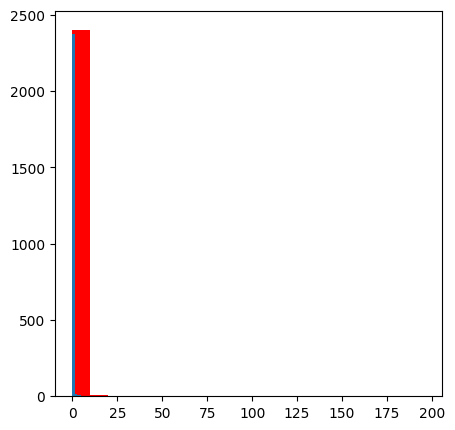

In [22]:
plt.figure(figsize = (5, 5))
control_visit_all = df['REVENUE'][df['VARIANT_NAME'] == 'control']
test_visit_all = df['REVENUE'][df['VARIANT_NAME'] == 'variant']
plt.hist(control_visit_all, color = 'r',bins = 20)
plt.hist(test_visit_all,bins = 20)
plt.show()

<Axes: xlabel='REVENUE', ylabel='Count'>

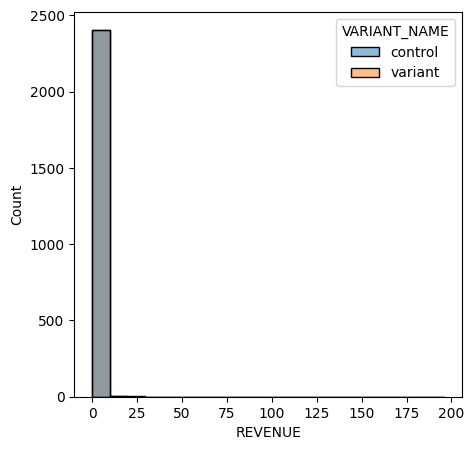

In [23]:
plt.figure(figsize = (5, 5))
sns.histplot(data = df, x = 'REVENUE', bins = 20, hue = 'VARIANT_NAME')

<Axes: xlabel='REVENUE', ylabel='Count'>

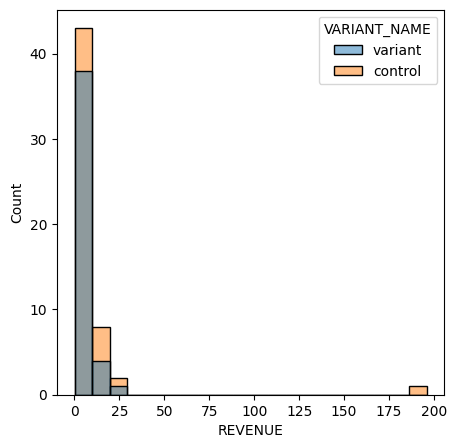

In [24]:
plt.figure(figsize = (5, 5))
sns.histplot(data = df[df['conversion'] == 1], x = 'REVENUE', bins = 20, hue = 'VARIANT_NAME')

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

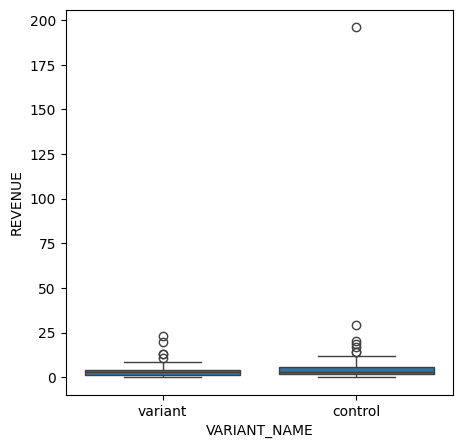

In [25]:
plt.figure(figsize = (5, 5))
sns.boxplot(data = df[df['conversion'] == 1], y = 'REVENUE', x = 'VARIANT_NAME')

### По графикам видно, что распределения ненормальные, много выбросов, так же можно заметить, что группа рузультаты группы B хуже, чем группы А. Низкая конверсия в покупку. Вторая рекомендация - проверить длительность теста, чтобы увеличить объем данных.

### Для проверки нормальности используем критерий Шапиро-Уилка.

In [26]:
alpha = 0.05
pvalue = stats.shapiro(df['REVENUE'])[1]
print('Распределение ' + ['','НЕ'][pvalue < alpha] + ' нормальное')

Распределение НЕ нормальное


### Так как распределение ненормальное, группах мало данных и существуют выбросы, то используем критерий Манна-Уитни.

In [27]:
stats.mannwhitneyu(x = A['REVENUE'].values, y = B['REVENUE'].values)

MannwhitneyuResult(statistic=2918468.0, pvalue=0.26069244720791673)

In [28]:
M1 = A['REVENUE'].mean() 
M2 = B['REVENUE'].mean()
D1 = A['REVENUE'].var()
D2 = B['REVENUE'].var()

### При уровне значимости $a$=0.05 p-value=0.26 больше, следовательно, статистически значимой разницы между группами нет.

### Посчитаем эффективность наших выборок, чтобы анализировать результаты.

In [30]:
effect_size = (M1 - M2) / np.sqrt(((n1 - 1) * D1 + (n2 - 1) * D2) / (n1 + n2 - 2))
effect_size

0.04015622200081145

In [31]:
analysis = TTestIndPower()
analysis.solve_power(effect_size = effect_size, alpha = alpha, power = None, nobs1 = n1, ratio = n2 / n1)

0.28604403832813124

### Эффективность теста равна примерно 29%, с такой эффективностью мы не можем быть уверены в результатах теста. Мы могли не получить статистически значимую разницу, т.к. у нас недостаточный объем выборки.
